In [1]:
# TITLE        :: PRACTICE ONE-CLASS SUPPORT VECTOR MACHINE MODEL (CLASSIFICAITION)
# AUTHOR       :: CHOI SANG HEON
# CREATED DATE :: 2023-04-07 (FRI)
# UPDATED DATE :: 2023-10-05 (THUR)

## 00. **SET WORK ENVORINMENT**

#### 01.1. **DEFINE PRE-VARIABLES**

In [2]:
seed_num = 2023
worker_num = 8

#### 00.2. **IMPORT PACKAGES AND SET PACKAGE OPTIONS**

In [3]:
#(1) Import packages
import os
import warnings
import math 
import numpy as np
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics

#(2) Set system options
warnings.filterwarnings(action="ignore")
pd.options.display.float_format = "{:.5f}".format
np.set_printoptions(precision=3, suppress=True)
# plt.rcParams["font.family"] = "D2Coding"

### 00.2. **CREATE USER-DEFINED FUNCTIONS** 

In [4]:
#(1) Create `relocate_col()` function
def relocate_col(df:pd.DataFrame, tar_col:str, std_col:str, how:str="after") -> pd.DataFrame :
    col_list = df.columns
    tar_col_idx = np.where(col_list == tar_col)[0][0]
    col_list = np.delete(arr=col_list, obj=tar_col_idx)
    std_col_idx = np.where(col_list == std_col)[0][0]
    if how == "before" : 
        col_list = np.insert(arr=col_list, obj=std_col_idx, values=tar_col)
    else : 
        col_list = np.insert(arr=col_list, obj=std_col_idx+1, values=tar_col)        
    return_value = df.loc[:, col_list]  
    return return_value

#(2) Create `diagnose_df()` function
def diagnose_df(df:pd.DataFrame) -> pd.DataFrame :
    return_value = pd.DataFrame(data=df.dtypes).reset_index()
    return_value.columns = ["COLUMN_NM", "DATA_TYPE"]
    return_value.loc[:, "ROW_CNT"] = len(df)
    return_value.loc[:, "NA_CNT"] = df.isna().sum().values
    return_value.loc[:, "NA_RATE"] = return_value.loc[:, "NA_CNT"] / return_value.loc[:, "ROW_CNT"]
    return_value.loc[:, "UNIQUE_CNT"] = df.nunique().values
    return_value.loc[:, "UNIQUE_RATE"] = return_value.loc[:, "UNIQUE_CNT"] / return_value.loc[:, "ROW_CNT"]
    return return_value

#(3) Create `diagnose_num_df()` function
def diagnose_num_df(df:pd.DataFrame) -> pd.DataFrame : 
    return_value = df.describe(include="all", percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).transpose()
    return_value.loc[:, "median"] = df.median()
    return_value.loc[:, "mode"] = df.mode().values[0]
    return_value = relocate_col(df=return_value, tar_col="median", std_col="mean", how="after")
    return_value = relocate_col(df=return_value, tar_col="mode", std_col="median", how="after")
    return_value.columns = np.array(object=list(map(np.char.upper, return_value.columns)))
    return_value = return_value.rename(columns={"COUNT" : "ROW_CNT"})
    return return_value

#(4) Create `hist_subplot()` function
def hist_subplot(df:pd.DataFrame, main_title:str, fig_size:tuple, col_size:int) -> plt.figure :
    row_size = math.ceil((len(df.columns)/col_size))
    subplot_setter = plt.subplots(nrows=row_size, ncols=col_size, figsize=fig_size)
    figure = subplot_setter[0]
    axes = subplot_setter[1]
    plt.tight_layout(w_pad=2.5)
    figure.suptitle(t=main_title, fontweight="bold", fontsize=16, y=0.99)
    figure.subplots_adjust(top=0.8)
    row_idx=0
    col_idx=0
    for i in np.arange(stop=len(df.columns)) :
        axes[row_idx, col_idx].hist(x=df.loc[:, df.columns[i]])
        axes[row_idx, col_idx].grid(visible=True)
        axes[row_idx, col_idx].set_title(label=df.columns[i])
        col_idx = col_idx + 1
        if col_idx == col_size :
            row_idx = row_idx + 1 
            col_idx = 0
    subplot_deleter = (row_size * col_size) - len(df.columns)
    if subplot_deleter != 0 :
        for i in np.arange(stop=subplot_deleter) :
            axes[row_idx, col_idx].axis("off")
            col_idx = col_idx +1
    plt.tight_layout()
    return plt.show()

#(5) Create `box_subplot()` function
def box_subplot(df:pd.DataFrame, main_title:str, fig_size:tuple, col_size:int) -> plt.figure :
    row_size = math.ceil((len(df.columns)/col_size))
    subplot_setter = plt.subplots(nrows=row_size, ncols=col_size, figsize=fig_size)
    figure = subplot_setter[0]
    axes = subplot_setter[1]
    plt.tight_layout(w_pad=2.5)
    figure.suptitle(t=main_title, fontweight="bold", fontsize=16, y=0.99)
    figure.subplots_adjust(top=0.8)
    row_idx=0
    col_idx=0
    for i in np.arange(stop=len(df.columns)) :
        axes[row_idx, col_idx].boxplot(x=df.loc[:, df.columns[i]])
        axes[row_idx, col_idx].grid(visible=True)
        axes[row_idx, col_idx].set_title(label=df.columns[i])
        col_idx = col_idx + 1
        if col_idx == col_size :
            row_idx = row_idx + 1 
            col_idx = 0
    subplot_deleter = (row_size * col_size) - len(df.columns)
    if subplot_deleter != 0 :
        for i in np.arange(stop=subplot_deleter) :
            axes[row_idx, col_idx].axis("off")
            col_idx = col_idx +1
    plt.tight_layout()
    return plt.show()

## 01. **READ AND SPLIT DATASETS**

#### 01.1. **READ DATASET**

In [5]:
#(1) Read `credit_raw` dataframe
read_credit_path_01 = f"{os.getcwd()}/../data/credit"
read_credit_path_02 = os.listdir(path=read_credit_path_01)
for i in np.arange(stop=len(read_credit_path_02)) : 
    globals()[f'{read_credit_path_02[i].replace(".csv", "")}'] = pd.read_table(
        filepath_or_buffer=f'{read_credit_path_01}/{read_credit_path_02[i]}',
        sep=r','
    )
    print(f'>> READ DONE. FILE NAME IS "{read_credit_path_02[i]}".')

>> READ DONE. FILE NAME IS "credit_raw.csv".


#### 01.2. **SPLIT TRAIN AND TEST DATASET**

In [6]:
#(1) Split train-test datasets 
data_spliter = model_selection.train_test_split(credit_raw, test_size=0.3, train_size=0.7, random_state=seed_num, stratify=credit_raw.loc[:, "Class"])
credit_train = data_spliter[0]
credit_test = data_spliter[1]

#(2) Print train and test dataset shape
print(f">> TRAIN DATASET SHAPE : {credit_train.shape}")
print(f">> TEST  DATASET SHAPE : {credit_test.shape}")

>> TRAIN DATASET SHAPE : (199364, 31)
>> TEST  DATASET SHAPE : (85443, 31)


## 02. **EDA TRAIN DATASET**

#### 02.1. **EDA BY STRUCTURED FORMAT**

In [7]:
#(1) Print `credit_train` dataframe 
credit_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
112599,72720.00000,0.97105,-0.70885,-0.40122,-1.15752,-0.63863,-1.42089,0.55843,-0.49054,1.06295,...,0.08881,0.13827,-0.35195,0.51958,0.79858,0.05229,-0.03952,0.03825,195.77000,0
127350,78301.00000,1.43071,-0.92670,-0.01482,-1.43582,-1.15201,-0.97081,-0.51899,-0.25089,-2.46765,...,-0.43016,-1.01569,0.10579,0.28579,0.30071,-0.47160,-0.00709,0.01226,51.98000,0
229166,145823.00000,1.97849,-0.07269,-0.92123,1.02614,0.28253,0.34447,-0.30233,0.12654,0.47153,...,0.06231,0.30327,0.14136,0.19326,0.03465,-0.67595,0.03009,-0.04689,2.00000,0
127120,78216.00000,-0.37461,1.18675,1.52817,0.18131,-0.18987,-1.27567,0.75680,-0.13501,-0.50486,...,-0.22391,-0.55132,0.04287,0.87996,-0.21569,0.03729,0.24987,0.10460,2.58000,0
252209,155697.00000,2.06114,0.09371,-1.29386,0.32868,0.15604,-1.12862,0.29044,-0.40276,0.37486,...,0.27667,0.98594,0.06675,1.21581,0.28009,-0.17138,-0.01599,-0.04543,0.79000,0


In [8]:
#(2) Diagnose `credit_train` dataframe
diagnose_df(df=credit_train)

,COLUMN_NM,DATA_TYPE,ROW_CNT,NA_CNT,NA_RATE,UNIQUE_CNT,UNIQUE_RATE
0,Time,float64,199364,0,0.00000,107130,0.53736
1,V1,float64,199364,0,0.00000,194160,0.97390
2,V2,float64,199364,0,0.00000,194160,0.97390
3,V3,float64,199364,0,0.00000,194160,0.97390
4,V4,float64,199364,0,0.00000,194160,0.97390
5,V5,float64,199364,0,0.00000,194160,0.97390
6,V6,float64,199364,0,0.00000,194160,0.97390
7,V7,float64,199364,0,0.00000,194160,0.97390
8,V8,float64,199364,0,0.00000,194160,0.97390
9,V9,float64,199364,0,0.00000,194160,0.97390


In [9]:
#(3) Define index, feature, target variables
credit_train_dn = diagnose_df(df=credit_train)
CON = (credit_train_dn.loc[:, "COLUMN_NM"] == "Class")
credit_train_dn.loc[CON, "COLUMN_TYPE"] = "TARGET"
credit_train_dn.loc[~CON, "COLUMN_TYPE"] = "FEATURE"
credit_train_dn = relocate_col(df=credit_train_dn, tar_col="COLUMN_TYPE", std_col="DATA_TYPE", how="before")
credit_train_dn

,COLUMN_NM,COLUMN_TYPE,DATA_TYPE,ROW_CNT,NA_CNT,NA_RATE,UNIQUE_CNT,UNIQUE_RATE
0,Time,FEATURE,float64,199364,0,0.00000,107130,0.53736
1,V1,FEATURE,float64,199364,0,0.00000,194160,0.97390
2,V2,FEATURE,float64,199364,0,0.00000,194160,0.97390
3,V3,FEATURE,float64,199364,0,0.00000,194160,0.97390
4,V4,FEATURE,float64,199364,0,0.00000,194160,0.97390
5,V5,FEATURE,float64,199364,0,0.00000,194160,0.97390
6,V6,FEATURE,float64,199364,0,0.00000,194160,0.97390
7,V7,FEATURE,float64,199364,0,0.00000,194160,0.97390
8,V8,FEATURE,float64,199364,0,0.00000,194160,0.97390
9,V9,FEATURE,float64,199364,0,0.00000,194160,0.97390


In [10]:
#(4) Print basic statistics for numeric data
diagnose_num_df(df=credit_train)

,ROW_CNT,MEAN,MEDIAN,MODE,STD,MIN,1%,10%,25%,50%,75%,90%,99%,MAX
Time,199364.00000,94794.57307,84634.50000,163152.00000,47469.88029,0.00000,2440.00000,35016.00000,54196.75000,84634.50000,139227.00000,157633.70000,170556.00000,172792.00000
V1,199364.00000,-0.00008,0.01996,2.05580,1.97484,-56.40751,-6.61422,-1.89291,-0.91902,0.01996,1.31629,2.01590,2.23738,2.45493
V2,199364.00000,-0.00350,0.06654,-0.32667,1.67635,-72.71573,-4.99567,-1.36082,-0.59783,0.06654,0.80165,1.32445,3.80723,22.05773
V3,199364.00000,-0.00377,0.17672,-2.75204,1.52567,-48.32559,-3.96780,-1.80560,-0.89330,0.17672,1.02510,1.67422,2.72580,9.38256
V4,199364.00000,0.00182,-0.01691,-0.84232,1.41711,-5.68317,-3.12181,-1.65364,-0.84679,-0.01691,0.74173,1.48271,4.24835,16.87534
V5,199364.00000,0.00058,-0.05317,2.46307,1.39526,-113.74331,-3.07340,-1.30159,-0.68867,-0.05317,0.61379,1.40713,3.41212,34.80167
V6,199364.00000,-0.00125,-0.27595,3.17386,1.33609,-26.16051,-2.13196,-1.16634,-0.76707,-0.27595,0.39560,1.50375,4.20186,73.30163
V7,199364.00000,0.00038,0.04095,-0.43213,1.25873,-43.55724,-3.01852,-1.07729,-0.55043,0.04095,0.57037,1.03786,2.71060,120.58949
V8,199364.00000,0.00114,0.02224,0.72771,1.19653,-73.21672,-4.05737,-0.45706,-0.20842,0.02224,0.32754,0.76894,2.07282,20.00721
V9,199364.00000,-0.00002,-0.05037,0.60861,1.09702,-13.32015,-2.45798,-1.29192,-0.64077,-0.05037,0.59562,1.29849,2.97860,15.59499


In [11]:
#(5) Print `credit_train` dataframe correlation
credit_train_cr = credit_train.corr()
credit_train_cr

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.00000,0.12022,-0.01275,-0.41516,-0.10665,0.17260,-0.06186,0.08407,-0.03810,-0.00855,...,0.04595,0.14318,0.05180,-0.01803,-0.23391,-0.04071,-0.00444,-0.00853,-0.01081,-0.01299
V1,0.12022,1.00000,0.01779,0.01014,-0.00847,0.00606,0.00027,0.00239,-0.00280,0.00310,...,0.01021,-0.00023,0.00881,-0.00193,0.00118,-0.00065,-0.00346,-0.00103,-0.23527,-0.10507
V2,-0.01275,0.01779,1.00000,0.00519,-0.00841,-0.00182,0.00067,-0.01087,0.00609,-0.00446,...,-0.00967,0.00699,0.00727,-0.00259,0.00165,0.00021,-0.00651,-0.00535,-0.53637,0.08981
V3,-0.41516,0.01014,0.00519,1.00000,-0.00723,0.01150,-0.00243,0.00027,0.00011,0.00362,...,0.00837,-0.00013,0.00614,-0.00050,0.00012,0.00026,0.00050,0.00306,-0.21629,-0.19767
V4,-0.10665,-0.00847,-0.00841,-0.00723,1.00000,-0.00532,-0.00016,-0.00082,-0.00062,0.00118,...,-0.00244,-0.00086,-0.00470,-0.00060,-0.00019,-0.00062,0.00277,-0.00103,0.10518,0.13660
V5,0.17260,0.00606,-0.00182,0.01150,-0.00532,1.00000,-0.01046,-0.01342,0.00043,0.00460,...,0.00354,-0.00010,0.00280,-0.00221,-0.00100,-0.00065,-0.00204,0.00971,-0.39030,-0.09711
V6,-0.06186,0.00027,0.00067,-0.00243,-0.00016,-0.01046,1.00000,0.01205,-0.00262,-0.00067,...,-0.00699,0.00364,-0.00020,0.00123,-0.00103,0.00064,0.00489,-0.00535,0.21845,-0.04548
V7,0.08407,0.00239,-0.01087,0.00027,-0.00082,-0.01342,0.01205,1.00000,-0.00359,0.00348,...,0.02046,-0.00665,0.00412,-0.00081,0.00514,0.00112,0.01344,-0.00368,0.40455,-0.19361
V8,-0.03810,-0.00280,0.00609,0.00011,-0.00062,0.00043,-0.00262,-0.00359,1.00000,0.00292,...,0.04979,-0.01411,0.00676,0.00070,0.00186,0.00053,0.00077,-0.00006,-0.10599,0.02921
V9,-0.00855,0.00310,-0.00446,0.00362,0.00118,0.00460,-0.00067,0.00348,0.00292,1.00000,...,0.00105,-0.00135,-0.00023,0.00063,-0.00185,0.00042,0.00466,0.00452,-0.04364,-0.10226


In [12]:
#(6) Check correlation >= 0.1 variables
credit_train_cr_con = pd.DataFrame()
for i in np.arange(stop=len(credit_train_cr.index)) :
    CON = np.abs(credit_train_cr.loc[:, credit_train_cr.index[i]]) >= 0.1
    TEMP = pd.DataFrame(data={
        "COL_NM"     : [credit_train_cr.index[i]],
        "CORR>=0.1" : [list(credit_train_cr.loc[CON, credit_train_cr.index[i]].index)]
    })
    credit_train_cr_con = pd.concat(objs=[credit_train_cr_con, TEMP], axis=0)
credit_train_cr_con = credit_train_cr_con.reset_index(drop=True)
credit_train_cr_con

,COL_NM,CORR>=0.1
0,Time,"[Time, V1, V3, V4, V5, V11, V12, V15, V22, V25]"
1,V1,"[Time, V1, Amount, Class]"
2,V2,"[V2, Amount]"
3,V3,"[Time, V3, Amount, Class]"
4,V4,"[Time, V4, Amount, Class]"
5,V5,"[Time, V5, Amount]"
6,V6,"[V6, Amount]"
7,V7,"[V7, Amount, Class]"
8,V8,"[V8, Amount]"
9,V9,"[V9, Class]"


In [13]:
#(7) Print `Class`(target) variable ratio
pd.DataFrame(data=(
    credit_train.loc[:, "Class"].value_counts() / len(credit_train)
))

,count
Class,
0,0.99827
1,0.00173


#### 02.2. **EDA BY VISUALIZATION**

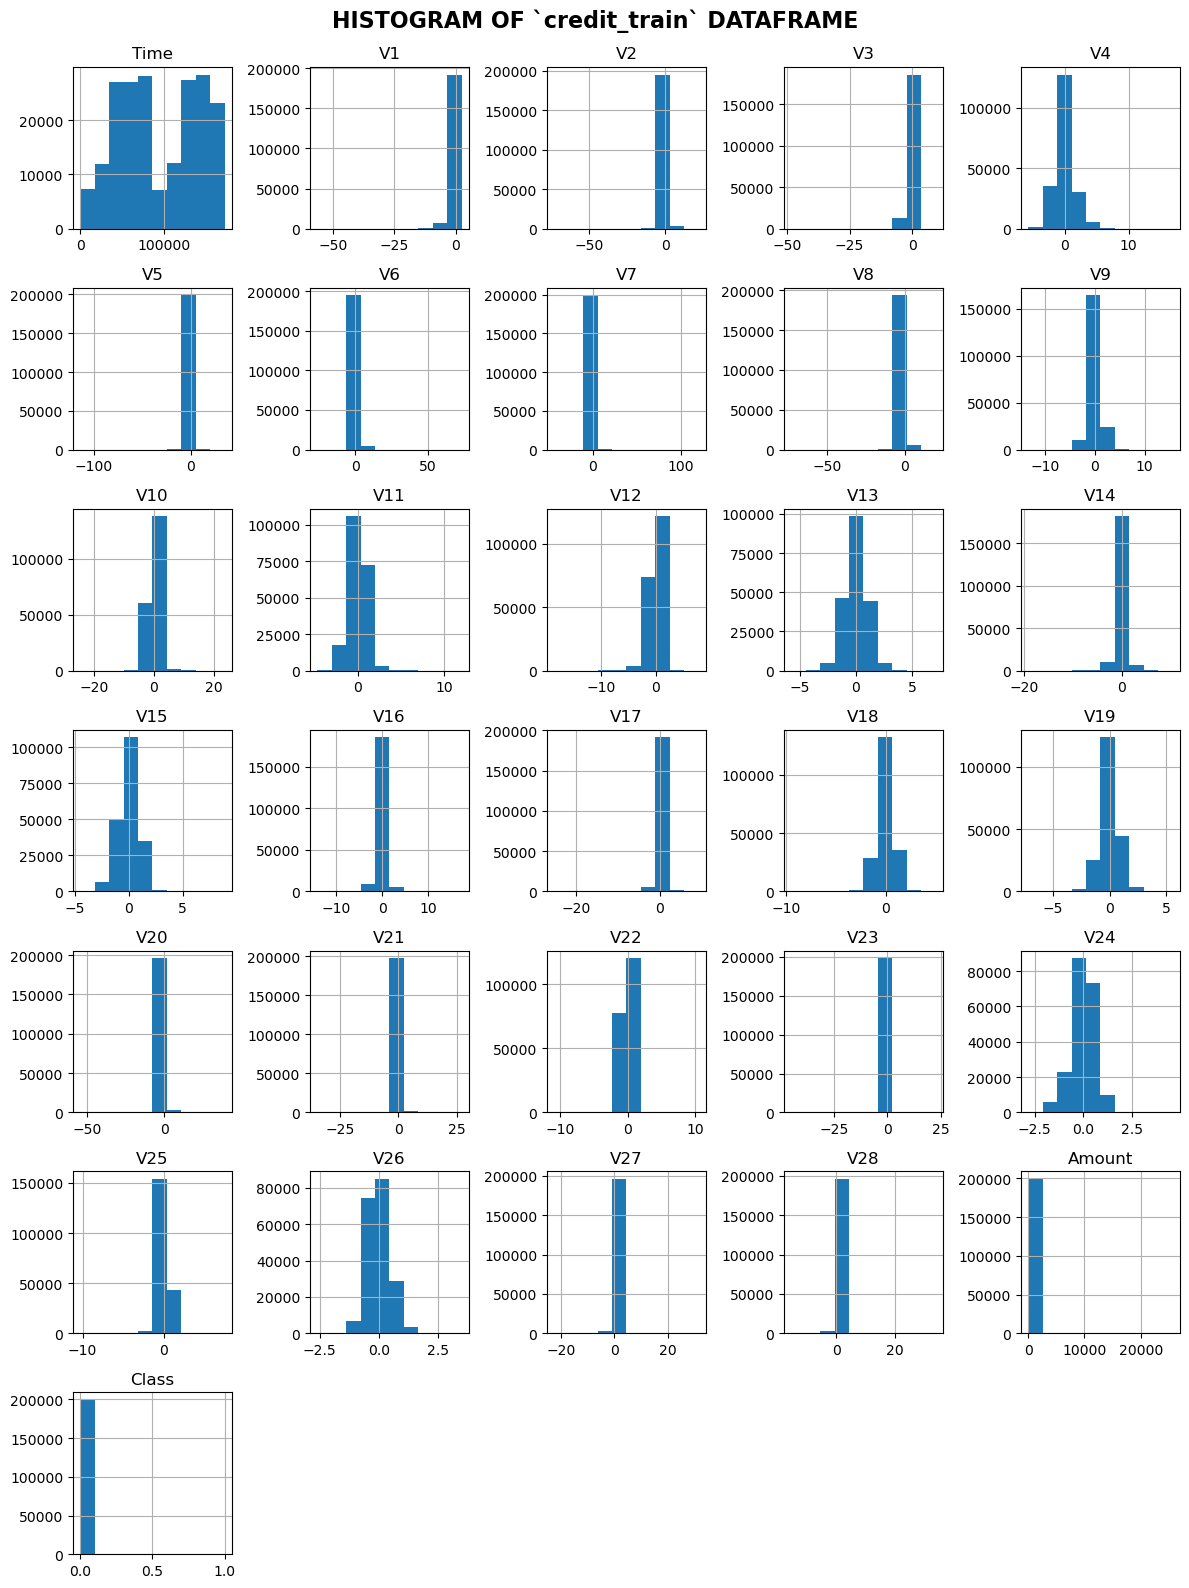

In [14]:
#(1) Print histogram
hist_subplot(df=credit_train, main_title="HISTOGRAM OF `credit_train` DATAFRAME", col_size=5, fig_size=(12, 16))

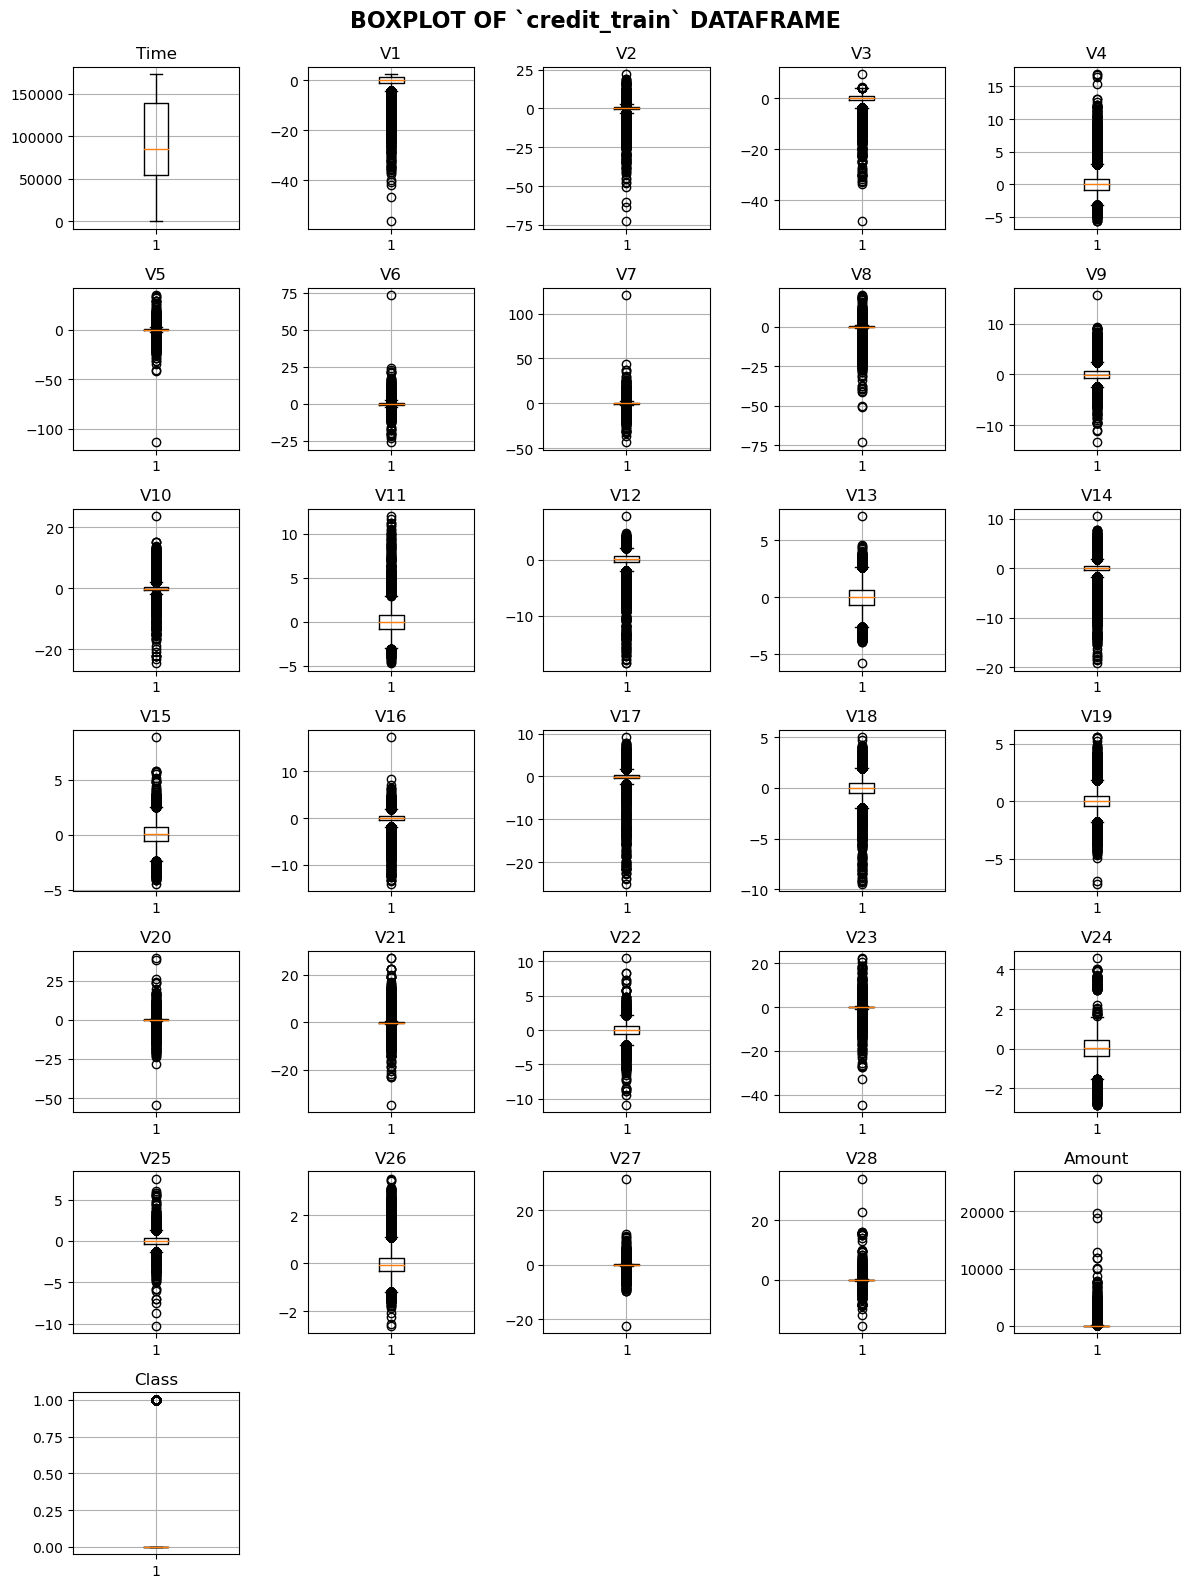

In [15]:
#(2) Print box-plot
box_subplot(df=credit_train, main_title="BOXPLOT OF `credit_train` DATAFRAME", col_size=5, fig_size=(12, 16))

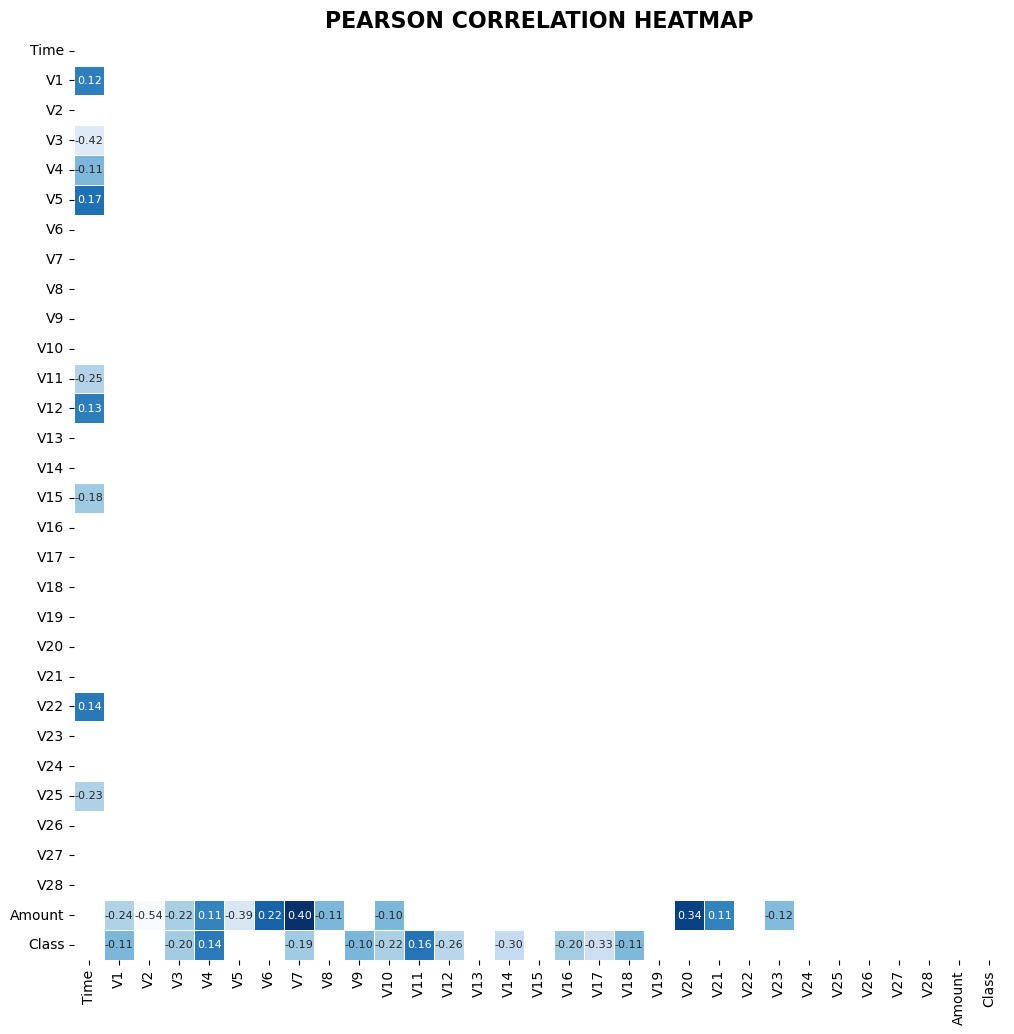

In [16]:
#(5) Print correlation heatmap (|corr| >= 0.1)
credit_train_cr_con = credit_train_cr.copy()
for i in np.arange(stop=len(credit_train_cr_con.columns)) :
    CON = (np.absolute(credit_train_cr_con.loc[:, credit_train_cr_con.columns[i]]) <= 0.1) | (np.absolute(credit_train_cr_con.loc[:, credit_train_cr_con.columns[i]]) == 1)
    credit_train_cr_con.loc[CON, credit_train_cr_con.columns[i]] = np.nan
plt.figure(figsize=(12, 12))
plt.title(label="PEARSON CORRELATION HEATMAP", fontweight="bold", fontsize=16)
sns.heatmap(
    data=credit_train_cr_con, 
    annot=True, 
    annot_kws={"size":8}, 
    fmt = ".2f", 
    linewidths=.5, 
    cmap="Blues", 
    cbar=False, 
    mask=np.triu(np.ones_like(a=credit_train_cr_con, dtype=bool))
)
plt.show()

## 03. **PREPROCESS TRAIN DATASET**

#### 03.1. **SPLIT X AND Y**

In [17]:
#(1) Split `{*}_X` dataframe
CON = (credit_train_dn.loc[:, "COLUMN_TYPE"]=="FEATURE")
train_col_list = credit_train_dn.loc[CON, "COLUMN_NM"].values
credit_train_X = credit_train.loc[:, train_col_list]
credit_test_X = credit_test.loc[:, train_col_list]

#(2) Split `{*}_y` dataframe
CON = (credit_train_dn.loc[:, "COLUMN_TYPE"]=="TARGET")
test_col_list = credit_train_dn.loc[CON, "COLUMN_NM"].values
credit_train_y = credit_train.loc[:, test_col_list]
credit_test_y = credit_test.loc[:, test_col_list]

#(3) Print dataframe's shape
print(f'>> TRAIN DATASET SHAPE :: {credit_train_X.shape}, {credit_train_y.shape}')
print(f'>>  TEST DATASET SHAPE :: {credit_train_X.shape}, {credit_test_y.shape}')

>> TRAIN DATASET SHAPE :: (199364, 30), (199364, 1)
>>  TEST DATASET SHAPE :: (199364, 30), (85443, 1)


#### 03.2. **SCALE USING ROBUST-SCALER**

In [18]:
#(1) Scale `credit_train` dataframe
scaler = preprocessing.RobustScaler()
scaler.fit(X=credit_train_X)
credit_train_X_scaled = pd.DataFrame(data=scaler.transform(X=credit_train_X), columns=train_col_list, index=credit_train_X.index)

#(2) Print `credit_train_X` dataframe
credit_train_X_scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
112599,-0.14012,0.42549,-0.55406,-0.30126,-0.71803,-0.44951,-0.98475,0.46171,-0.95674,0.90047,...,1.25053,0.28510,0.12306,-1.09791,0.60166,1.16685,0.18335,-0.25050,0.20650,2.42492
127350,-0.07449,0.63112,-0.70972,-0.09985,-0.89322,-0.84367,-0.59764,-0.49959,-0.50961,-1.95512,...,-0.52848,-0.96925,-0.95742,0.37605,0.30736,0.42356,-0.74076,-0.04965,0.00840,0.41836
229166,0.71961,0.87618,-0.09949,-0.57233,0.65662,0.25774,0.53362,-0.30628,0.19461,0.42212,...,-0.47383,0.22106,0.27754,0.49057,0.19088,0.02635,-1.10122,0.18059,-0.44261,-0.27910
127120,-0.07548,-0.17652,0.80044,0.70447,0.12478,-0.10496,-0.85984,0.63869,-0.29339,-0.36760,...,0.54679,-0.47074,-0.52262,0.17343,1.05533,-0.34739,0.15689,1.54170,0.71243,-0.27100
252209,0.83573,0.91316,0.01942,-0.76656,0.21756,0.16062,-0.73337,0.22260,-0.79297,0.34393,...,-0.25405,0.73914,0.91674,0.25032,1.47812,0.39278,-0.21119,-0.10478,-0.43148,-0.29598


#### 03.3. **CHECK PREPROCESSING BY VISUALIZATION**

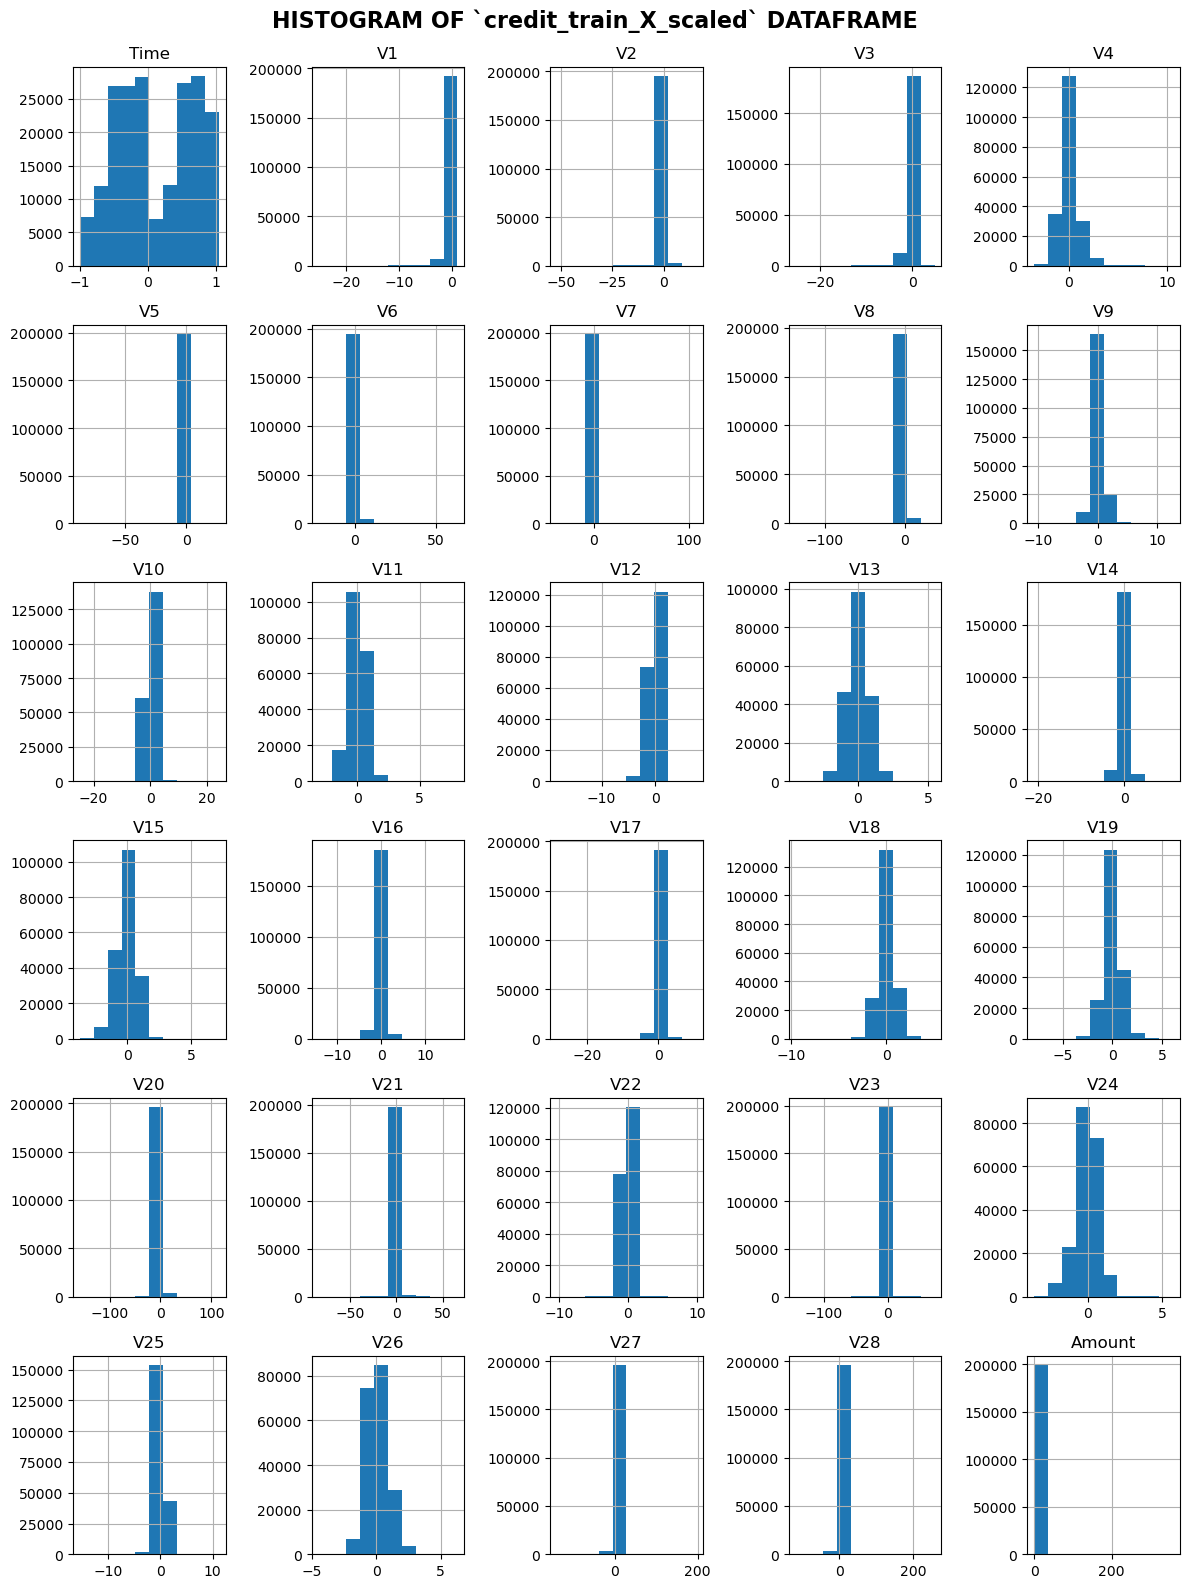

In [19]:
#(1) Print histogram
hist_subplot(df=credit_train_X_scaled, main_title="HISTOGRAM OF `credit_train_X_scaled` DATAFRAME", col_size=5, fig_size=(12, 16))

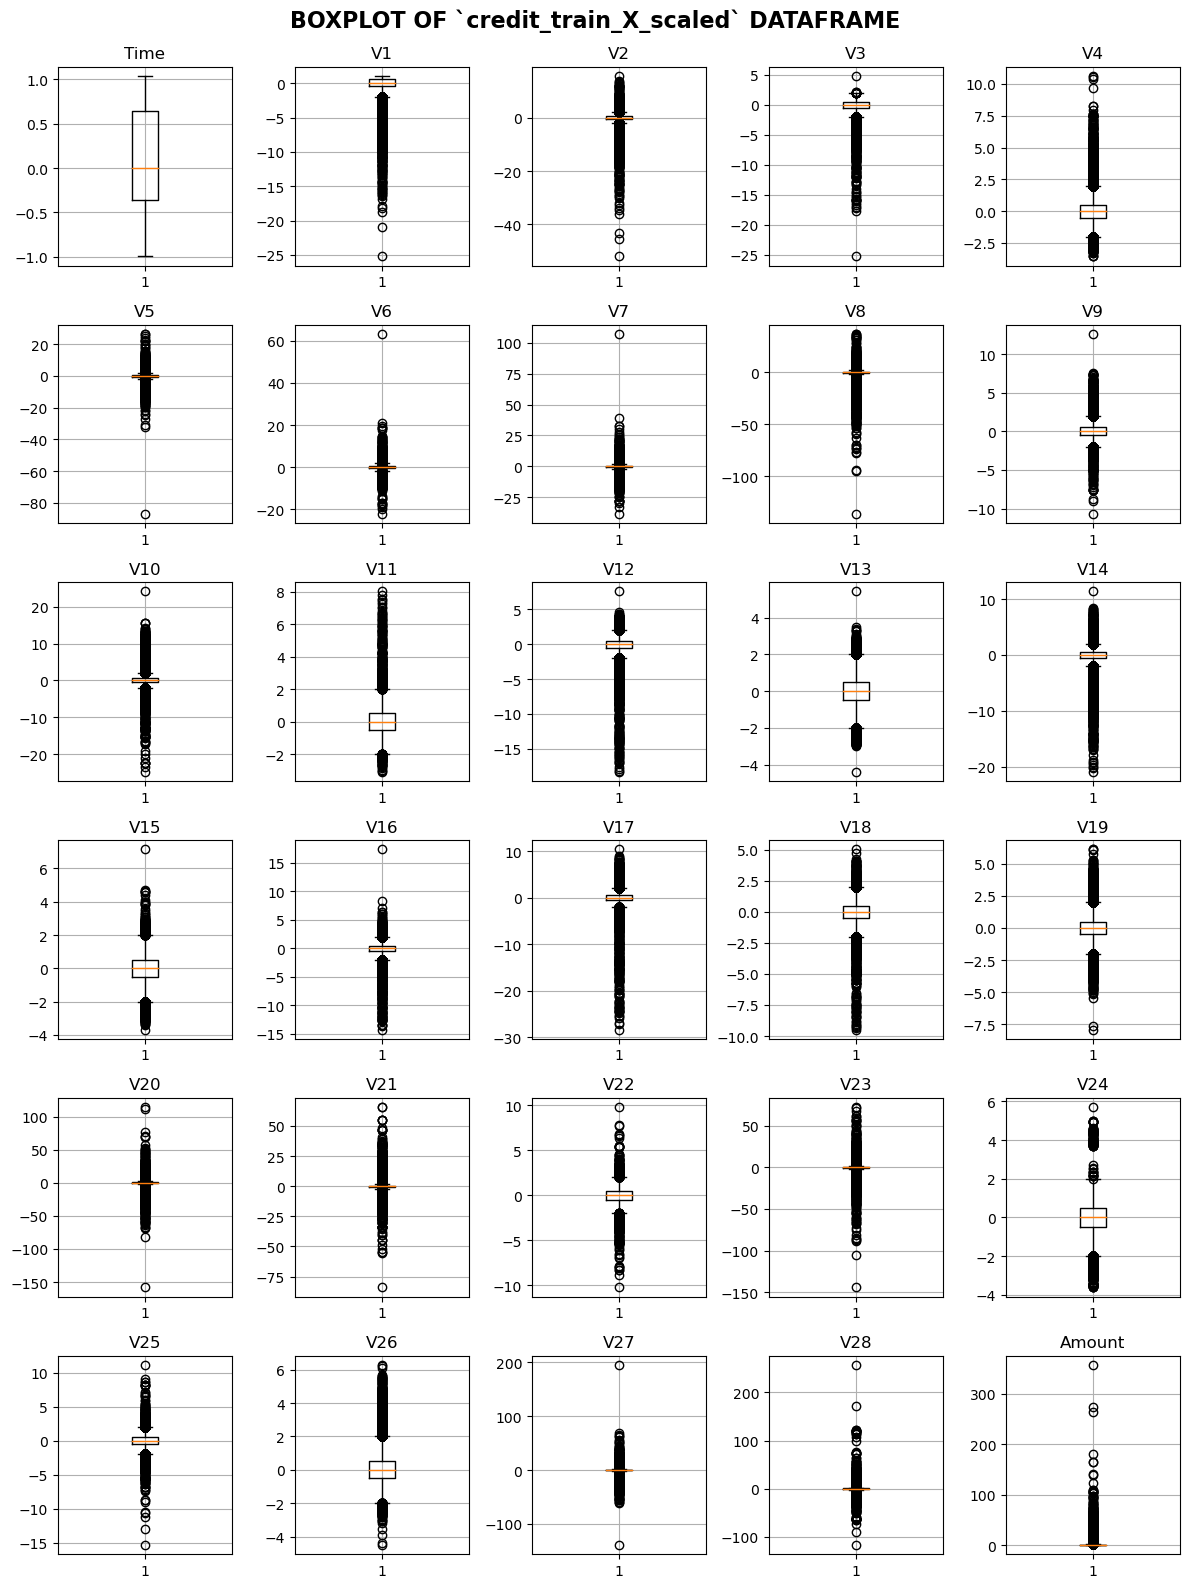

In [20]:
#(2) Print box-plot
box_subplot(df=credit_train_X_scaled, main_title="BOXPLOT OF `credit_train_X_scaled` DATAFRAME", col_size=5, fig_size=(12, 16))

#### 03.4. **TRANSFORM TARGET VARIABLE**

In [21]:
#(1) Transform target variable
credit_train_y_transformed = credit_train_y.copy()
CON = (credit_train_y_transformed.loc[:, "Class"] == 1)
credit_train_y_transformed.loc[CON, "Class"] = -1
CON = (credit_train_y_transformed.loc[:, "Class"] == 0)
credit_train_y_transformed.loc[CON, "Class"] = 1

#(2) Print `Class`(target) variable ratio
pd.DataFrame(data=credit_train_y_transformed.value_counts())

,count
Class,
1,199020
-1,344


## 04. **APPLY TEST DATASET**

#### 04.1. **SCALE USING ROBUST-SCALER**

In [22]:
#(1) Scale `credit_test` dataframe
credit_test_X_scaled = pd.DataFrame(data=scaler.transform(X=credit_test_X), columns=train_col_list, index=credit_test_X.index)

#(2) Print `credit_test_X` dataframe
credit_test_X_scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
66702,-0.38173,-0.28739,0.37869,0.76567,-0.25041,0.22844,-0.60570,0.43636,0.05450,-0.44557,...,-0.13114,-0.07347,-0.35885,0.31869,0.57623,-0.96317,-0.16880,0.46390,1.02346,-0.29459
196649,0.55260,-0.12746,0.12864,0.34694,-0.62968,0.62696,0.40206,0.13517,0.39656,0.03723,...,0.17474,-0.15211,-0.34160,0.72331,0.18149,-1.86432,0.21097,0.99584,1.61566,-0.14680
88551,-0.26397,-0.32103,0.63714,0.92619,0.35317,-0.11068,-0.53813,0.72533,-0.14063,-0.37928,...,-0.05299,0.42359,0.26356,-0.90590,0.80887,0.73154,-0.40346,0.24247,0.46742,0.11094
174446,0.43844,0.82785,-1.28704,-1.10898,-1.14527,0.86673,3.44507,-1.41526,1.71055,-0.00176,...,1.20661,1.23828,0.93643,0.18915,0.89042,-0.34692,-0.01615,0.04910,-0.28313,1.85599
23011,-0.61265,-0.59880,-0.09884,1.02284,0.02977,-1.03140,0.76160,0.10478,0.32758,1.17578,...,-0.53465,0.20837,0.83643,0.56261,0.60009,-0.62591,2.10930,0.47424,1.65141,1.55010


#### 04.2. **TRANSFORM TARGET VARIABLE**

In [23]:
#(1) Transform target variable
credit_test_y_transformed = credit_test_y.copy()
CON = (credit_test_y_transformed.loc[:, "Class"] == 1)
credit_test_y_transformed.loc[CON, "Class"] = -1
CON = (credit_test_y_transformed.loc[:, "Class"] == 0)
credit_test_y_transformed.loc[CON, "Class"] = 1

#(2) Print `Class`(target) variable ratio
pd.DataFrame(data=credit_test_y_transformed.value_counts())

,count
Class,
1,85295
-1,148


## 04. **TRAIN AND TEST MODEL**

#### 04.1. **SEARCH BEST HYPER PARAMETER**

In [24]:
#(1) Define model object
oc_svm = svm.OneClassSVM()

#(2) Define hyper-parameter grid
oc_svm_params = {
    "kernel" : ["linear", "poly", "rbf"],
    "nu"     : np.arange(start=0.5, stop=1, step=0.1)
}

#(3) Tune hyper parameters
oc_svm_tune = model_selection.GridSearchCV(
    estimator=oc_svm,
    param_grid=oc_svm_params,
    scoring=metrics.make_scorer(score_func=metrics.f1_score, average="weighted"),
    cv=3,
    n_jobs=worker_num
)

#(4) Fit train dataset
oc_svm_fit = oc_svm_tune.fit(X=credit_train_X_scaled, y=credit_train_y_transformed)

#(5) Print best cross-validation result
pd.DataFrame(data=oc_svm_fit.cv_results_).loc[:, ["params", "mean_test_score", "std_test_score"]].head()

,params,mean_test_score,std_test_score
0,"{'kernel': 'linear', 'nu': 0.5}",0.66451,0.00236
1,"{'kernel': 'linear', 'nu': 0.6}",0.56864,0.00187
2,"{'kernel': 'linear', 'nu': 0.7}",0.45871,0.00206
3,"{'kernel': 'linear', 'nu': 0.7999999999999999}",0.33083,0.00296
4,"{'kernel': 'linear', 'nu': 0.8999999999999999}",0.18056,0.00212


#### 04.2. **EVALUATE MODEL**

In [25]:
#(1) Predict test datasets
oc_svm_predict = oc_svm_fit.predict(X=credit_test_X_scaled)

#(2) Print `svm_OC_predict`
oc_svm_predict

array([ 1,  1,  1, ..., -1, -1,  1])

In [26]:
#(3) Print confusion matrix
pd.DataFrame(data=metrics.confusion_matrix(y_true=credit_test_y_transformed, y_pred=oc_svm_predict), columns=["PREDICT_(-1)", "PREDICT_(+1)"], index=["TRUE_(-1)", "TRUE_(+1)"])

,PREDICT_(-1),PREDICT_(+1)
TRUE_(-1),144,4
TRUE_(+1),42796,42499


In [27]:
#(4) Print accuracy score
metrics.accuracy_score(y_true=credit_test_y_transformed, y_pred=oc_svm_predict)

0.49908125885092985

In [28]:
#(5) Print precesion score
metrics.precision_score(y_true=credit_test_y_transformed, y_pred=oc_svm_predict)

0.9999058889960709

In [29]:
#(6) Print recall score
metrics.recall_score(y_true=credit_test_y_transformed, y_pred=oc_svm_predict)

0.4982589835277566

In [30]:
#(7) Print f1 score 
metrics.f1_score(y_true=credit_test_y_transformed, y_pred=oc_svm_predict)

0.6650964803831046

In [31]:
#(8) Print roc-auc score
metrics.roc_auc_score(y_true=credit_test_y_transformed, y_score=oc_svm_predict)

0.7356159782503648

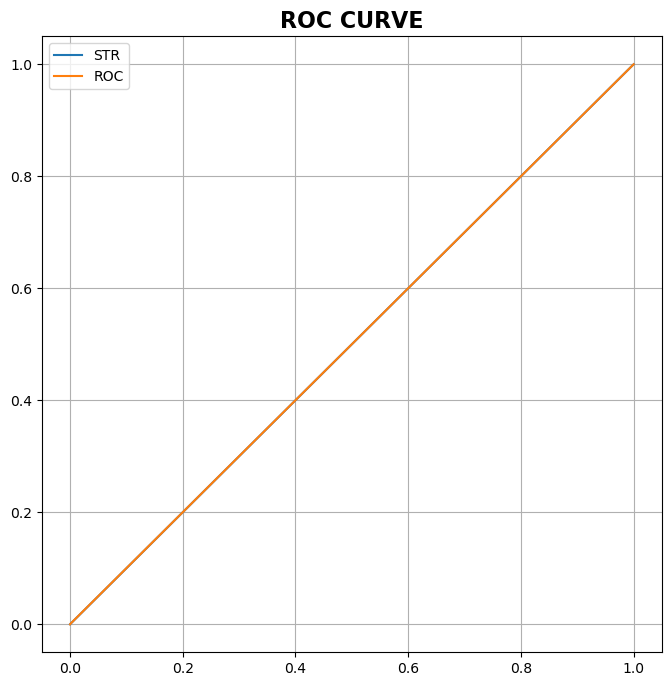

In [32]:
#(9) Print roc-auc curves
roc_values = metrics.roc_curve(y_true=credit_test_y_transformed, y_score=oc_svm_fit.decision_function(X=credit_test_X))
fprs = roc_values[0]
tprs = roc_values[1]
ths = roc_values[2]
plt.figure(figsize=(8, 8))
plt.title(label="ROC CURVE", fontweight="bold", fontsize=16)
plt.plot([0,1], [0,1], label="STR")
plt.plot(fprs, tprs, label="ROC")
plt.legend()
plt.grid()
plt.show()